In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn
% matplotlib inline

import pandas as pd

### Create sum of normals data

In [2]:
## Loop. Create I cases of the observed totals of the q quantiles.

I = 1000
T = 16

df_q_list = []
for Q in [10, 15, 20]:
    x = np.arange(0, 1, 1/Q) + .5/Q
    v = 1.5 - x
    for q in range(Q):
        block_q = np.random.normal(0, v[q], (I, T)) # generate data (*)
        df_q = pd.DataFrame(block_q) # as dataframe
        # add indexer columns
        df_q['q'] = q
        df_q['Q'] = Q
        df_q = df_q.reset_index().rename(columns = {'index': 'i'})
        df_q = df_q.set_index(['Q', 'q', 'i'])
        df_q_list += [df_q]
        
df = pd.concat(df_q_list)

# (*) In the real case, these rows will not just be a gaussian but the sum of powers.
# This is interesting per se and there are results to obtain here. 

# Using size dist and growth rates we can have nice estimations of std vs quantile.

# The colored bands I have from before are based on the real size dists. 
# They have the kind of problem that apparently there can be aggregate shocks, 
# or some baseline that will not be fully subtracted, 
# so that in large numbers volatility goes down to this base level.


In [3]:
# I = 500. T = 16
# the block is I x T
# It has some random or gaussian values.
# Actually it should be the logdiff.
# This log comes from the sum, ie. size dist plus growth rates.
# block_q

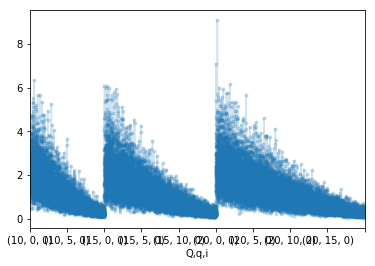

In [4]:
# Ok, now we have a dataset with generated random values for the quantiles, in many possible draws.
# It is indexed by Q, q, i and each line is a simultaion of the values of such quantile in linear scale.

# We can add a column with the variance of each row. 
df['var_qi'] = df.var(1)
df.var(1).plot(marker = '.', alpha = .2)


In [5]:
# If we test the Taylor expansion estimator on the simple sum of gaussians case, we should get coefficients of 1. 
# It is a test bed...

## Load data

In [25]:
## Import 
# df = pd.read_csv('./../../data/processed/exp_var_lapl_1s_s0.3.csv').set_index(['Q', 'q', 'i']).sort_index()
df = pd.read_csv('./../../data/processed/exp_var_norm_1s_s0.3.csv').set_index(['Q', 'q', 'i']).sort_index()
# df = pd.read_csv('./../../data/processed/exp_var_sbtn_1s_s0.3.csv').set_index(['Q', 'q', 'i']).sort_index()

In [159]:
# # # Detailed look... what if the quantile levels are very disparate?
# # # We can call this a 'breach'. 
# # # What I will do is I will keep a fraction of the simulated cases (i), where difference between max an min is not crazy high.

# # # np.log10(df).median(1).groupby(level = [0, 1]).mean()

# # For all the experiments (Q, i) see min, median, max. 
# grouped = df.mean(1).groupby(level = [0, 2])
# # plt.hist(np.log10(grouped.max() - grouped.min()), 150)
# # plt.show()
# np.log10(grouped.max()).plot(alpha = .5)
# np.log10(grouped.min()).plot(alpha = .5)
# np.log10(grouped.median()).plot(alpha = .5)

# # # for l in np.log10(1.35*(10**11.5)/np.array([10, 15, 25])): plt.axhline(l, linestyle = '--')
# # # for l in np.log10((10**11.5)/np.array([10, 15, 25])): plt.axhline(l)

# # plt.ylim(10, 11.5)
# # plt.show()

# # Histogram of values
# # plt.hist(np.log10(df.loc[10].iloc[:, :15].values.flatten()), 150, alpha = .5)
# # plt.hist(np.log10(df.loc[15].iloc[:, :15].values.flatten()), 150, alpha = .5)
# # plt.hist(np.log10(df.loc[25].iloc[:, :15].values.flatten()), 150, alpha = .5)
# # for l in np.log10(1.35*(10**11.5)/np.array([10, 15, 25])): plt.axvline(l)
# # plt.xlim(9, 11.5)
# # plt.show()

#### Drop runs where quantiles are very disparate

In [175]:
I = 1000; keep = int(.5*I)
grouped = df.mean(1).groupby(level = [0, 2])
acceptables = (np.log10(grouped.max()) - np.log10(grouped.min())).groupby(level = 0).nsmallest(keep).sort_index()
acceptables.index = acceptables.index.droplevel(0)

# new df
df = df.reset_index().set_index(['Q', 'i']).loc[acceptables.index].reset_index().set_index(['Q', 'q', 'i'])
# df.groupby(['Q', 'q']).count().sample(10)

In [182]:
# Median blocks.
df['dev_median'] = df.groupby(level=[0,1]).apply(lambda x: abs(x - x.median()))['var_qi']#.plot(marker = '.')
df_median_pool = df.groupby(level=[0,1]).apply(lambda x: x.nsmallest(3, 'dev_median').reset_index(drop = True))
df_lowvar_pool = df.groupby(level=[0,1]).apply(lambda x: x.nsmallest(3, 'var_qi').reset_index(drop = True))

info = np.log10(df.iloc[:, :T]).var(1).groupby(level=[0,1]).describe()[['mean', '25%', '50%', '75%']]#.sum()


## Size distribution

Here we can recover the n of the quantiles

In [162]:
# from scipy.special import erf


# sigma = 1.3149476902828778
# mu = 4.470439741406725

# # 13% of guys that would be below the .3 threshold.
# z = (mu - 3)/sigma
# cum_th = 1 - .5*(1 + erf(z/np.sqrt(2)))

# from scipy.stats import norm

# N = int(1e5)
# N_ = int(round(N/(1 - cum_th)))

# x1 = np.array([norm.ppf(q, mu, sigma) for q in np.arange(0, 1, 1/N_) + .5/N_])
# x1 = x1[(-N - 1):-1]


In [163]:
def get_n(x1, Q):
    x_lin = np.power(10, x1)
    bins = pd.cut(pd.Series(np.cumsum(x_lin)), Q)
    ns = bins.value_counts().values
    return bins, ns

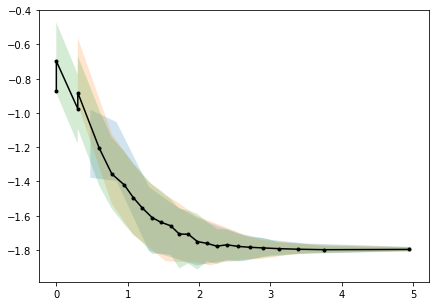

In [164]:
# df#.groupby(level=[0,1]).describe()
fig, ax = plt.subplots(1, figsize = (7, 5))
# np.log10().var()
for Q in ([10, 15, 25]):
    bins, ns = get_n(x1, Q)
    x = np.log10(ns)
#     x = np.arange(Q)/Q
    
    ax.fill_between(x, np.log10(info.loc[Q]['25%'].values),
                    np.log10(info.loc[Q]['75%'].values), alpha = .2)
ax.plot(x, np.log10(info.loc[Q]['50%'].values), marker = '.', c = 'k')
    

In [165]:
import warnings
warnings.filterwarnings('ignore')

In [183]:
# Taylor estimator.

# access blocks from the df.

Q_ = 15 #10, 15
df_Q = df.loc[Q_]
# df_mp_Q = df_median_pool.loc[Q_]
df_mp_Q = df_lowvar_pool.loc[Q_]

df_xy_list = []

for q in range(Q_):
    print(q)
    df_q = df_Q.loc[q]

    # Option 1. Sample median blocks only once. Shuffling of other blocks will not introduce noise.
    df_median_m = df_mp_Q.groupby(level=[0]).apply(lambda x: x.sample(1).reset_index(drop = True))
    
    df_q_part = df_q
    var_i_list = []
    for i, row in df_q_part.iterrows(): # not necessary to have all I's.
    # Option 2. Sample median each time. Incorporate uncertainty of other blocks. #TOO NOISY
#         df_median_m = df_mp_Q.groupby(level=[0]).apply(lambda x: x.sample(1).reset_index(drop = True))
    # (we want to avoid a fixed 'angle' of the vector with the 16 levels of the rest of the qs. 
    # As it will deform the outcome of sigma_qi's in a determined way)
    
        # Insert the i row in place of the median for q.
        dfm = df_median_m
        df_i = df_median_m.copy()
        row = pd.DataFrame(row).T
        row.index = pd.MultiIndex.from_product([[q], row.index])
        df_i = df_i.drop(q).append(row)
        
        # Do the total, get it's var. this is 'y'. store
#         var_i = df_i[range(T)].sum().var()
        var_i = np.log10(df_i.iloc[:, :T].sum()).var() # we possibly want the var of logs.
        var_i_list += [var_i]
    df_xy = df_q_part[['var_qi']]
    df_xy['y'] = np.array(var_i_list)
    df_xy['q'] = q
    
    df_xy_list += [df_xy]
    
df_xy = pd.concat(df_xy_list)
# The 'x' are the sigma i. They are already in df.

# I have an x, y. Store it.


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


## Zero ordinate for different x_0

In [737]:
x0_s_dist

0       1       2       3       4       5       6       7  \
dist s                                                                     
lapl 0.1  0.0002  0.0011  0.0020  0.0029  0.0039  0.0048  0.0057  0.0066   
     0.2  0.0018  0.0065  0.0113  0.0160  0.0207  0.0254  0.0302  0.0349   
     0.3  0.0074  0.0202  0.0329  0.0457  0.0584  0.0711  0.0839  0.0966   
     0.4  0.0165  0.0439  0.0713  0.0987  0.1261  0.1535  0.1809  0.2083   
     0.5  0.0322  0.0886  0.1449  0.2013  0.2576  0.3139  0.3703  0.4266   
norm 0.1  0.0002  0.0010  0.0017  0.0025  0.0033  0.0040  0.0048  0.0056   
     0.2  0.0021  0.0065  0.0109  0.0153  0.0198  0.0242  0.0286  0.0330   
     0.3  0.0074  0.0168  0.0263  0.0357  0.0452  0.0546  0.0641  0.0735   
     0.4  0.0200  0.0416  0.0633  0.0849  0.1065  0.1282  0.1498  0.1715   
     0.5  0.0412  0.0800  0.1188  0.1576  0.1964  0.2352  0.2740  0.3129   

               8       9  
dist s                    
lapl 0.1  0.0076  0.0085  
     0.2  0.0396  0.0443  
     0.3  0.1094  0.1221  
     0.4  0.2357  0.2631  
     0.5  0.4830  0.5393  
norm 0.1  0.0063  0.0071  
     0.2  0.0374  0.0418  
     0.3  0.0830  0.0924  
     0.4  0.1931  0.2148  
     0.5  0.3517  0.3905

In [842]:
# Here we do an experiment where we set levels of background variance and see the oo of the dependence with many quantiles.
# The idea is to have a correct idea of the dependence around zero.
# I have seen an expression where var = var_q/Q. How does it look in real 

## Import 
# df = pd.read_csv('./../../data/processed/exp_var_lapl_1s_s0.3.csv').set_index(['Q', 'q', 'i']).sort_index()
# df = pd.read_csv('./../../data/processed/exp_var_sbtn_1s_s0.3.csv').set_index(['Q', 'q', 'i']).sort_index()

df_xy_list = []

for dist in ['norm', 'lapl']:
    for s in ['0.1', '0.2', '0.3', '0.4', '0.5']:
        # Load previously simulated
        df = pd.read_csv('./../../data/processed/exp_var_'+dist+'_1s_s'+s+'_lntail.csv').set_index(['Q', 'q', 'i']).sort_index()

        ### 
        # DROP CASES WHERE QUANTILES ARE FAR FROM BALANCED
        ###

        I = 1000; keep = int(.5*I)
        grouped = df.mean(1).groupby(level = [0, 2])
        acceptables = (np.log10(grouped.max()) - np.log10(grouped.min())).groupby(level = 0).nsmallest(keep).sort_index()
        acceptables.index = acceptables.index.droplevel(0)
        # new df
        df = df.reset_index().set_index(['Q', 'i']).loc[acceptables.index].reset_index().set_index(['Q', 'q', 'i'])
        
        ###
        # DECIDE ON THE X0 LEVELS.
        ###
        # They could be the median or they could also be some fixed levels of x0. 

#         df['dev_median'] = df.groupby(level=[0,1]).apply(lambda x: abs(x - x.median()))['var_qi']#.plot(marker = '.')
#         df_x0var_pool = df.groupby(level=[0,1]).apply(lambda x: x.nsmallest(3, 'dev_median').reset_index(drop = True))

        values_check = df.reset_index()[['q', 'var_qi']].sort_values(by = ['q', 'var_qi'])
        s_dist_grouped = values_check.groupby('q').agg(['min', 'max'])['var_qi']

        # parametric pts between these values
        x0i = s_dist_grouped[['min']].quantile(.7).values
        x0f = s_dist_grouped[['max']].quantile(.3).values
        dist_s_x0_levels = (x0i + np.arange(0, 1, .1)*(x0f - x0i)).round(4)

        # # Pool of qi's with the required x0
        for x0 in dist_s_x0_levels:
            df['dev_x0'] = df.groupby(level=[0,1]).apply(lambda x: abs(x - x0))['var_qi']#.plot(marker = '.')
            df_x0var_pool = df.groupby(level=[0,1]).apply(lambda x: x.nsmallest(3, 'dev_x0').reset_index(drop = True))

            for Q_ in [20]:
                df_Q = df.loc[Q_]
                # df_mp_Q = df_median_pool.loc[Q_]
                df_mp_Q = df_x0var_pool.loc[Q_]

                # Option 1. Sample median blocks only once. Shuffling of other blocks will not introduce noise.
                df_median_m = df_mp_Q.groupby(level=[0]).apply(lambda x: x.sample(1).reset_index(drop = True))

                for q in range(Q_)[:5]:
                    print(s, x0, Q_, q)
                    df_q = df_Q.loc[q]
                    
                    df_q_part = df_q
                    var_i_list = []
                    for i, row in df_q_part.iterrows():
                        # Insert the i row in place of the median for q.
                        dfm = df_median_m
                        df_i = df_median_m.copy()
                        row = pd.DataFrame(row).T
                        row.index = pd.MultiIndex.from_product([[q], row.index])
                        df_i = df_i.drop(q).append(row)

                        # Do the total, get it's var. this is 'y'. store
                #         var_i = df_i[range(T)].sum().var()
                        var_i = np.log10(df_i.iloc[:, :T].sum()).var() # we possibly want the var of logs.
                        var_i_list += [var_i]
                    df_xy = df_q_part[['var_qi']]
                    df_xy['y'] = np.array(var_i_list)
                    df_xy['q'] = q
                    df_xy['Q'] = Q_
                    df_xy['s'] = float(s)
                    df_xy['dist'] = dist
                    df_xy['x0'] = x0

                    df_xy_list += [df_xy]

df_xy = pd.concat(df_xy_list)
df_xy['x0'] = df_xy.x0.round(4)
df_xy.to_csv('./../../data/processed/20190712_x0_depce_test_full3.csv')

0.1 0.0003 20 0
0.1 0.0003 20 1
0.1 0.0003 20 2
0.1 0.0003 20 3
0.1 0.0003 20 4
0.1 0.0016 20 0
0.1 0.0016 20 1
0.1 0.0016 20 2
0.1 0.0016 20 3
0.1 0.0016 20 4
0.1 0.0029 20 0
0.1 0.0029 20 1
0.1 0.0029 20 2
0.1 0.0029 20 3
0.1 0.0029 20 4
0.1 0.0042 20 0
0.1 0.0042 20 1
0.1 0.0042 20 2
0.1 0.0042 20 3
0.1 0.0042 20 4
0.1 0.0055 20 0
0.1 0.0055 20 1
0.1 0.0055 20 2
0.1 0.0055 20 3
0.1 0.0055 20 4
0.1 0.0068 20 0
0.1 0.0068 20 1
0.1 0.0068 20 2
0.1 0.0068 20 3
0.1 0.0068 20 4
0.1 0.0081 20 0
0.1 0.0081 20 1
0.1 0.0081 20 2
0.1 0.0081 20 3
0.1 0.0081 20 4
0.1 0.0094 20 0
0.1 0.0094 20 1
0.1 0.0094 20 2
0.1 0.0094 20 3
0.1 0.0094 20 4
0.1 0.0107 20 0
0.1 0.0107 20 1
0.1 0.0107 20 2
0.1 0.0107 20 3
0.1 0.0107 20 4
0.1 0.012 20 0
0.1 0.012 20 1
0.1 0.012 20 2
0.1 0.012 20 3
0.1 0.012 20 4
0.2 0.0015 20 0
0.2 0.0015 20 1
0.2 0.0015 20 2
0.2 0.0015 20 3
0.2 0.0015 20 4
0.2 0.0072 20 0
0.2 0.0072 20 1
0.2 0.0072 20 2
0.2 0.0072 20 3
0.2 0.0072 20 4
0.2 0.013 20 0
0.2 0.013 20 1
0.2 0.013 20 2


### Fit lines/parabolas for slope at x0.

In [851]:
# ## Load if needed 
df_xy1 = pd.read_csv('./../../data/processed/20190712_x0_depce_test_full.csv')
df_xy2 = pd.read_csv('./../../data/processed/20190712_x0_depce_test_full2.csv')
df_xy3 = pd.read_csv('./../../data/processed/20190712_x0_depce_test_full3.csv')
df_xy = pd.concat([df_xy1, df_xy2, df_xy3], axis = 0)

# Falta Q = 20, q in (0, 5)
# df_xy.groupby(['Q', 'q']).count().loc[20]

In [852]:
# Scale by s2. Careful not to run twice.

df_xy['var_qi'] = df_xy['var_qi']/(df_xy.s)**2
df_xy['y'] = df_xy['y']/(df_xy.s)**2
df_xy['x0'] = df_xy['x0']/(df_xy.s)**2

# Actually (var_qi - x0) should be now (t_qi - t0) and 'y' should be (sigma/s)

norm
10


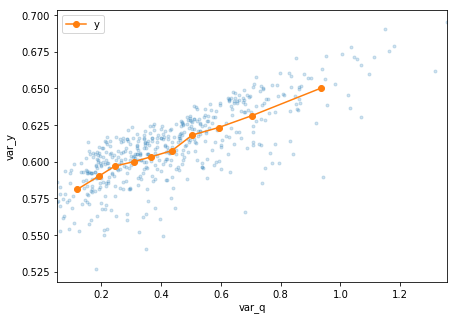

15


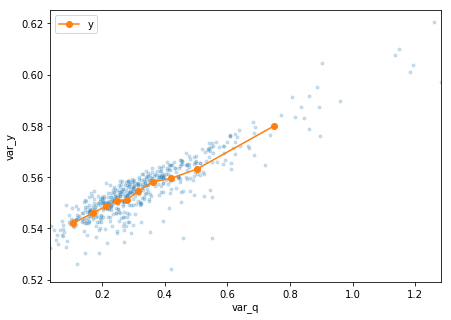

25


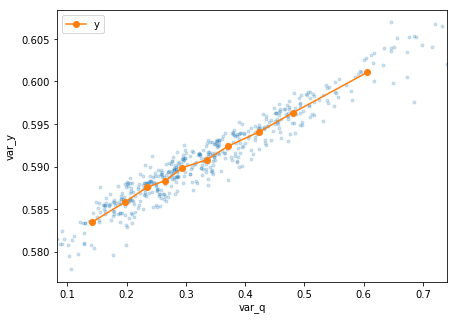

20


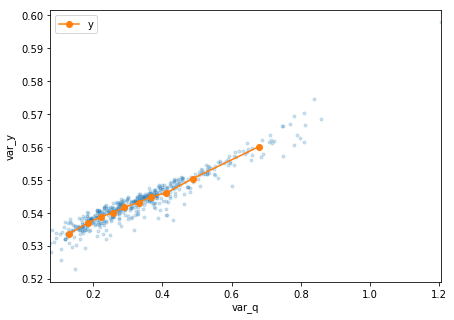

lapl
10


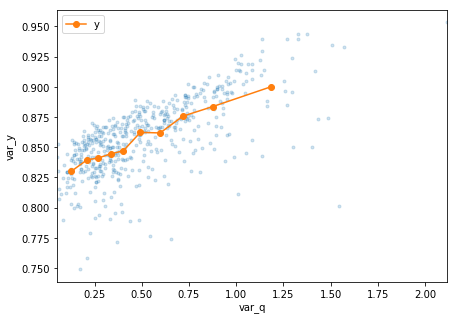

15


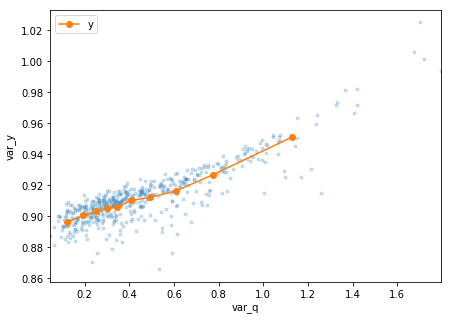

25


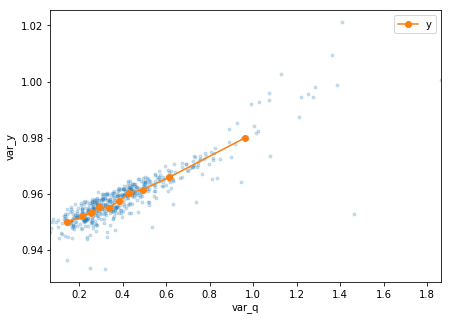

20


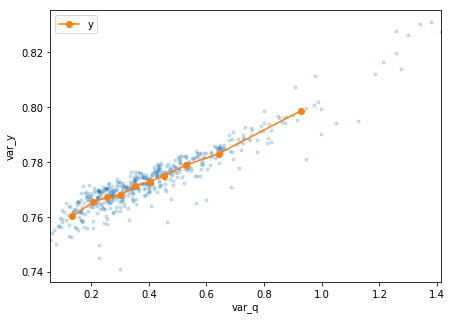

In [873]:
fits1 = []
fits2 = []
for dist in df_xy.dist.unique():
    print(dist)
    df_xy_d = df_xy.loc[df_xy.dist == dist]
    for Q in df_xy.Q.unique():
        print(Q)
        df_xy_dQ = df_xy_d.loc[df_xy_d.Q == Q]
        fig, ax = plt.subplots(1, figsize = (7, 5))
        for s in df_xy.s.unique():
            df_xy_dQs = df_xy_dQ.loc[df_xy_dQ.s == s]
            for q in range(Q):
                
                df_xy_dQqs = df_xy_dQs.loc[df_xy_dQs.q == q]
                for x0 in df_xy_dQqs.x0.unique():
                    df_xy_dQqs0 = df_xy_dQqs.loc[df_xy_dQqs.x0 == x0]

                    x = df_xy_dQqs0.var_qi
                    y = df_xy_dQqs0.y

                    line = np.polyfit(x, y, 1)
                    curv = np.polyfit(x, y, 2)

                    fits1 += [np.hstack((line, [q, Q, s, dist, x0]))]
                    fits2 += [np.hstack((curv, [q, Q, s, dist, x0]))]
                    
                    df_xy_q = df_xy.loc[df_xy.q == q]

                if (s, q) == (.4, 7):
                    df_xy_dQqs0 = df_xy_dQqs.loc[df_xy_dQqs.x0 == df_xy_dQqs.x0.unique()[5]]
                    ax.plot(df_xy_dQqs0.var_qi, df_xy_dQqs0.y, '.', alpha = .2)
                    bin_mean = df_xy_dQqs0.groupby(pd.qcut(df_xy_dQqs0.var_qi, 10)).mean()
                    bin_mean.plot('var_qi', 'y', marker = 'o', ax = ax)

                    # ax.set_xlim(min(x), max(x))
                    # ax.set_ylim(min(y), max(y))
                    ax.set_xlabel('var_q') 
                    ax.set_ylabel('var_y')
        plt.show()

In [854]:
fits1 = pd.DataFrame(np.array(fits1), columns = ['a', 'b', 'q', 'Q', 's', 'dist', 'x0'])
fits2 = pd.DataFrame(np.array(fits2), columns = ['a', 'b', 'c', 'q', 'Q', 's', 'dist', 'x0'])

for df_ in [fits1, fits2]:
    for col in df_.columns:
        df_[col] = pd.to_numeric(df_[col], errors='ignore')
    
# x = 0.03
# df_.a*x**2 + df_.b**x + df_.c

# fits1['s0'] = 2 * fits1.a * fits1.x0 + fits1.b
fits1['s0'] = fits1.a * fits1.x0 + fits1.b

fits1.to_csv('./../../data/processed/20190712_x0_depce_test_full_fits1.csv', index = False)
fits2.to_csv('./../../data/processed/20190712_x0_depce_test_full_fits2.csv', index = False)

# Analysis

KeyError: 's0'

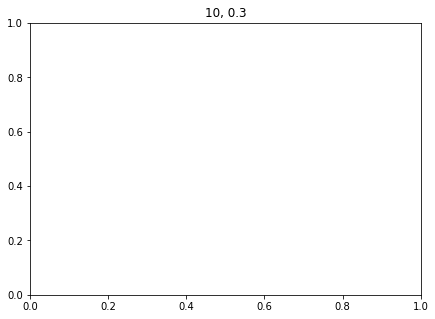

In [832]:
# # Dependence with Q and s


for Q_ in df_.Q.unique():
    fig, ax = plt.subplots(1, figsize = (7, 5))
    ax.set_title(str(Q_)+', '+str(s_))
    for s_ in df_.s.unique():
        df_.loc[(df_.Q == Q_) & (df_.s == s_)].plot('x0', 's0', marker = '.', lw = 0, ax = ax)
#         ax.set_xlim(0, 0.025)
#         ax.set_ylim(0, 0.04)
    plt.show()
    
# Attention. We want x0 values to be comfortably reachable. Otherwise I will just be having them clipped for some of the Q, s, q combinations.

values_check = df_xy.reset_index(drop = True).drop(['y', 'x0'], axis = 1).drop_duplicates().sort_values(by = ['q', 'var_qi'])
# grouped = values_check.loc[(values_check.dist == 'norm')].groupby(['Q', 's', 'q'])
grouped = values_check.groupby(['dist','s', 'q'])

fig, ax = plt.subplots(1, figsize = (17, 5))
grouped.agg(['min', 'max'])['var_qi'].plot(ax = ax)
# ax.axhline(0.01)
# ax.axhline(0.02)
# ax.set_ylim(0, 0.03)
ax.set_yscale('log')

s_dist_grouped = grouped.agg(['min', 'max'])['var_qi'].groupby(level = [0, 1])
x0_s_dist = pd.concat([s_dist_grouped['min'].quantile(.7) + \
           l*(s_dist_grouped['max'].quantile(.3) - s_dist_grouped['min'].quantile(.7)) for l in np.arange(0, 1, .1)], axis = 1).round(4)

df_ = grouped.agg(['min', 'max'])['var_qi'].reset_index().merge(x0_s_dist.reset_index()).set_index(['dist', 's', 'q'])
df_[range(10)].plot(color = '.4', linestyle = '--', ax = ax)
plt.show()

[0.418 0.004]
[0.471 0.003]
[0.436 0.002]


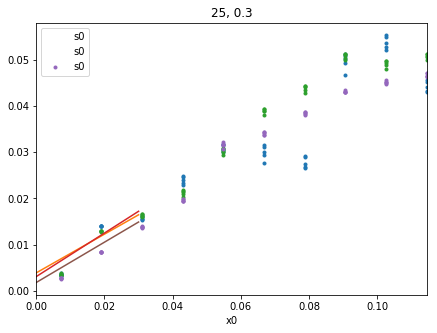

In [801]:
df_ = fits1.set_index(['dist']).loc['norm']
## Dependence with Q

fig, ax = plt.subplots(1, figsize = (7, 5))
aQ = []
for Q_ in df_.Q.unique():
    s_ = .3 
    ax.set_title(str(Q_)+', '+str(s_))
    data = df_.loc[(df_.Q == Q_) & (df_.s == s_)]
    data.plot('x0', 's0', marker = '.', lw = 0, ax = ax)
    
    line = np.polyfit(data.x0, data.s0, 1)
    ax.plot(np.arange(0, 0.035, 0.01), np.arange(0, 0.035, 0.01)*line[0] + line[1])
    print(line.round(3))
    # This is useful for a(Q). For now not a clearly explainable dependence
    aQ += [line[0]]
aQ = np.array(aQ) 
# ax.set_xlim(0, 0.025)
# ax.set_ylim(0, 0.04)
plt.show()

#### Partial derivatives at x0

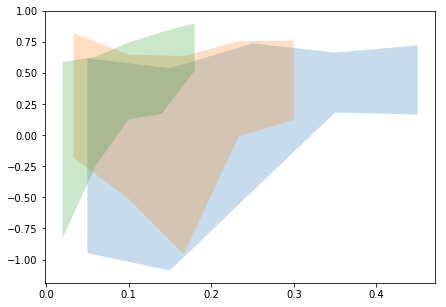

In [802]:
fits2['part_dev_x0'] = 2 * fits2.a * fits2.x0 + fits2.b
df_ = fits2.set_index(['dist']).loc['norm']

part_devs_q = df_.loc[df_.s == .3].groupby(['Q', 'q'])['part_dev_x0'].describe()[['mean', '25%','50%','75%']]
part_devs_q = part_devs_q.reset_index()
part_devs_q['pct'] = (part_devs_q['q'] + .5)/part_devs_q['Q']

fig, ax = plt.subplots(1, figsize = (7, 5))
for Q_ in part_devs_q.Q.unique():
    data = part_devs_q.loc[part_devs_q.Q == Q_]
    ax.fill_between(data.pct, Q_*data['25%'], Q_*data['75%'], alpha = .25)
plt.show()
# High q are the little populated, volatile ones.

### The $(\sigma^2_q - \sigma^2_0)$ term
Computed as difference between median and x0. It is just to have a qualitative idea, cause actually $\sigma^2_q$ will be given in each custom case

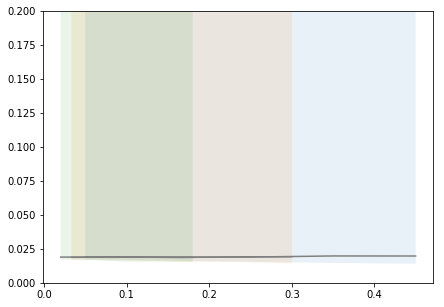

In [803]:
# describe var_qi by dist, Q, q, s (s = .3 for now)
describe = df_xy.loc[df_xy.s == .3].drop(['y','x0'], axis = 1).drop_duplicates().groupby(['dist','Q','q','s'])['var_qi'].describe()
describe = describe.loc['lapl']

describe = describe.reset_index()
describe['pct'] = (describe['q'] + .5)/describe['Q']

fig, ax = plt.subplots(1, figsize = (7, 5))
for Q_ in describe.Q.unique():
    data = describe.loc[describe.Q == Q_]
    ax.fill_between(data.pct, data['25%'], Q_*data['75%'], alpha = .1)
    ax.plot(data.pct, data['50%'], color = '.5')
# plt.yscale('log')
plt.ylim(0, 0.2)
plt.show()


## A term: $\frac{\partial \sigma^2}{\partial \sigma^2_q} (\sigma^2_q - \sigma^2_0) $

We use as x_0 = 0.02 as it is a quite good approx for all the pcts in the lower part of value.

In [804]:
x0_ = 0.019

In [805]:
# describe var_qi by dist, Q, q, s (s = .3 for now)
df_ = df_xy.loc[df_xy.s == .3].drop(['x0'], axis = 1).drop_duplicates()
df_ = df_xy.loc[(df_xy.s == .3) & (df_xy.x0 == x0_)]#.drop(['x0'], axis = 1).drop_duplicates()
describe_var_q = df_.groupby(['dist','Q','q','s'])[['var_qi', 'y']].describe()

df_ = fits2.loc[fits2.s == .3]
describe_part_dev_x0 = df_.groupby(['dist','Q', 'q', 's'])[['part_dev_x0']].describe()

describe = pd.concat([describe_var_q, describe_part_dev_x0], axis = 1)
describe = describe.iloc[:, describe.columns.get_level_values(1).isin(['25%','50%','75%'])]

describe = describe.reset_index()
describe['pct'] = (describe['q'] + .5)/describe['Q']

IndexError: list index out of range

AttributeError: 'DataFrame' object has no attribute 'dist'

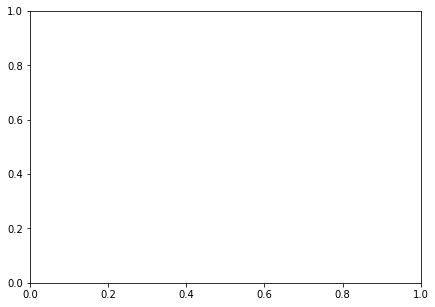

In [806]:
# I'm trying to reconstruct the y from a sum for all q of  ds/dsq .(sq - s0)

fig, ax = plt.subplots(1, figsize = (7, 5))
for i, Q_ in enumerate([10, 15, 25]):
    y0 = aQ[i] * x0_
    df_ = describe.loc[(describe.dist == 'norm') & (describe.Q == Q_)]
    # Evaluated at the medians:
    yq = Q_ * df_['part_dev_x0']['50%'] * (df_['var_qi']['50%'] - 0.019)
    yq = df_['part_dev_x0']['50%'] * (df_['var_qi']['50%'] - x0_)
    ax.plot(df_.pct, yq, marker = '.')
    ax.axhline(y0 , color = '.4')

describe.groupby(['dist', 'Q']).mean()['y'].plot(ax = ax) # Should be always the same value...
# plt.ylim(0, 0.02)

plt.show()
# It doesn quite work at the median... may be because, eg. in the median case all (x-x0) are positive, while 
# in particular cases they will be on both sides, therefor counteracting.

### xq are medians

AttributeError: 'DataFrame' object has no attribute 'dist'

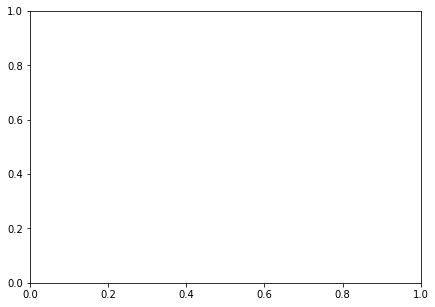

In [787]:
# I'm trying to reconstruct the y from a sum for all q of  ds/dsq .(sq - s0)

fig, ax = plt.subplots(1, figsize = (7, 5))
for i, Q_ in enumerate([10, 15, 25]):
    y0 = aQ[i] * x0_
    df_ = describe.loc[(describe.dist == 'norm') & (describe.Q == Q_)]
    # Evaluated at the medians:
    yq = Q_ * df_['part_dev_x0']['50%'] * (df_['var_qi']['50%'] - 0.019)
    yq = df_['part_dev_x0']['50%'] * (df_['var_qi']['50%'] - x0_)
    ax.plot(df_.pct, yq, marker = '.')
    ax.axhline(y0 , color = '.4')

describe.groupby(['dist', 'Q']).mean()['y'].plot(ax = ax) # Should be always the same value...
# plt.ylim(0, 0.02)

plt.show()
# It doesn quite work at the median... may be because, eg. in the median case all (x-x0) are positive, while 
# in particular cases they will be on both sides, therefor counteracting.

### xq are the xqi

In [651]:

for i, Q_ in enumerate([10, 15, 25]):
    y0 = aQ[i] * x0_
    df_ = describe.loc[(describe.dist == 'norm') & (describe.Q == Q_)]
    
    slice_ = df_xy.loc[(df_xy.s == .3) & (df_xy.dist == 'norm') & (df_xy.Q == Q_) & (df_xy.x0 == x0_)]
    slice_ = slice_.reset_index()
    part_dev_x0 = df_.set_index(['dist', 'Q' , 's', 'q','pct'])['part_dev_x0']['50%'].reset_index().rename(columns = {'50%': 'part_dev_x0'})
# debug. See var_y values for all the i experiments.
# slice_.groupby('i')['y'].describe()[['25%','50%','75%']].plot()
    slice_ = slice_.merge(part_dev_x0)
    slice_['xqi - x0'] = slice_['var_qi'] - slice_['x0']
    slice_['y0'] = y0
    slice_['(x-x0)dy/dx'] = slice_['part_dev_x0']*slice_['xqi - x0']
    slice_ = slice_.sort_values(by = ['i', 'q'])


(0, 0.03)

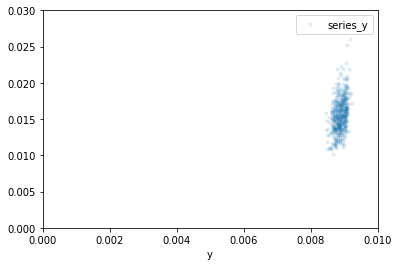

In [675]:
grouped = slice_.groupby('i')
series_approx = grouped['(x-x0)dy/dx'].sum() + grouped['y0'].first()
eval_series = grouped[['y']].quantile(.5)
eval_series['series_y'] = series_approx

eval_series.plot('y', 'series_y', marker = '.', lw = 0, alpha = .1)
plt.xlim(0, 0.01)
plt.ylim(0, 0.03)

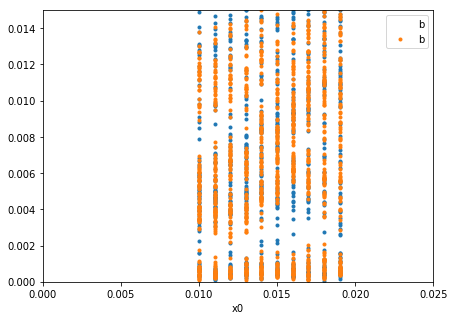

In [354]:
# oo are similar/equal for parabola or linear fits, as they should
# fits1['b2'] = fits2['c']
# fits1.plot('b2', 'b', marker = '.', lw = 0)

df_ = fits1.set_index('Q')[['q', 'x0', 'b']]

# df_['x0_'] = df_['x0'] + np.random.uniform(-0.0003, 0.0003, len(df_))

fig, ax = plt.subplots(1, figsize = (7, 5))
df_.loc[10].plot('x0', 'b', marker = '.', lw = 0, ax = ax)
df_.loc[15].plot('x0', 'b', marker = '.', lw = 0, ax = ax)
ax.set_xlim(0, 0.025)
ax.set_ylim(0, 0.015)
plt.show()

In [331]:
for Q in [10, 15]:
    x = df_.loc[Q]['x0']
    y = df_.loc[Q]['b']
    z = np.polyfit(x, y, 1)
    print(z)

[ 6.11258560e-01 -2.07949449e-04]
[ 5.66583178e-01 -3.52119285e-04]


In [ ]:
def qvars_fits(degree = 1):
    fits = []
    for q in range(Q_):
        df_xy_q = df_xy.loc[df_xy.q == q]
        # points
        x = df_xy_q.var_qi
        y = df_xy_q.y
        # fit
        z = np.polyfit(x, y, degree)
        fits += [z]
    fits = np.array(fits)
    return fits

In [244]:
qvars_fits(1)

array([[0.05847141, 0.00347405],
       [0.05443393, 0.00193246],
       [0.0560431 , 0.00236648],
       [0.04881516, 0.00201882],
       [0.05625421, 0.00229512],
       [0.06245085, 0.00383869],
       [0.04270722, 0.00239089],
       [0.03508963, 0.00175195],
       [0.03251947, 0.00206818],
       [0.03632867, 0.00237791]])

In [205]:
# low var values
df_mp_Q['var_qi'].groupby('q').max().sum()/(Q_**2)

0.0006697514151924629

(0, 0.02)

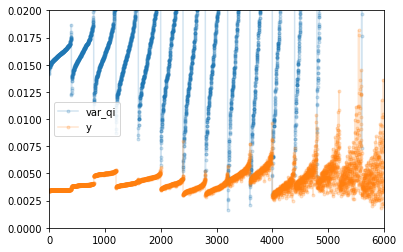

In [221]:
df_xy.sort_values(by = ['q', 'var_qi']).reset_index(drop = True)[['var_qi','y']].plot(marker = '.', alpha = .2)
# plt.yscale('log')
plt.ylim(0, 0.02)

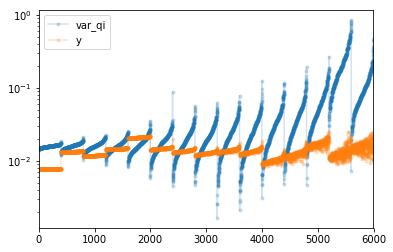

In [167]:
df_xy.sort_values(by = ['q', 'var_qi']).reset_index(drop = True)[['var_qi','y']].plot(marker = '.', alpha = .2)
plt.yscale('log')

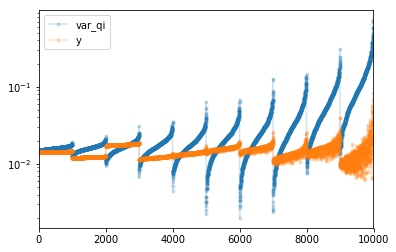

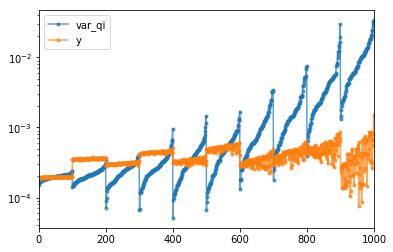

In [232]:
df_xy.sort_values(by = ['q', 'var_qi']).reset_index(drop = True)[['var_qi','y']].plot(marker = '.', alpha = .2)
plt.yscale('log')

In [ ]:
# For all the variables, get the x y's.
# fit poly, get coefficients, store. 
# option to plot.

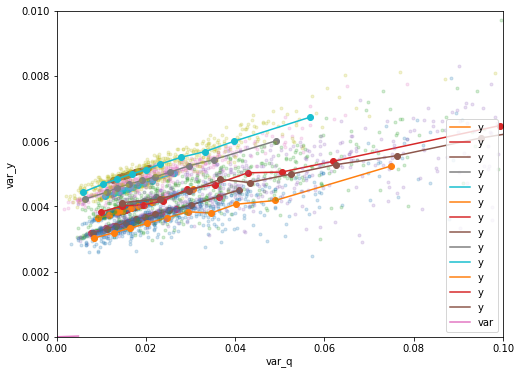

In [217]:
def qvars_fits(degree = 1):
    fits = []
    for q in range(Q_):
        df_xy_q = df_xy.loc[df_xy.q == q]
        # points
        x = df_xy_q.var_qi
        y = df_xy_q.y
        # fit
        z = np.polyfit(x, y, degree)
        fits += [z]
    fits = np.array(fits)
    return fits

fig, ax = plt.subplots(1, figsize = (8, 6))

for q in range(Q_)[:-2]:
    df_xy_q = df_xy.loc[df_xy.q == q]
    ax.plot(df_xy_q.var_qi, df_xy_q.y, '.', alpha = .2)
    bin_mean = df_xy_q.groupby(pd.qcut(df_xy_q.var_qi, 10)).mean()
    bin_mean.plot('var_qi', 'y', marker = 'o', ax = ax)

    # ax.set_xlim(min(x), max(x))
    # ax.set_ylim(min(y), max(y))
    ax.set_xlabel('var_q') 
    ax.set_ylabel('var_y')
    
slice_ = result.loc[result.Q == Q_]
slice_['var'] = slice_['var']#*Q_**2
slice_.plot('var_q', 'var', ax = ax)

ax.set_xlim(0, .1)
ax.set_ylim(0, 0.01)
plt.show()
    # Laplace

## Partial devs

In [188]:
def dx2(x, a, b, c):
    return 2 * a * x + b

def dx(x, a, b):
    return a

In [189]:
partial_devs_1 = np.array([dx(np.median(x), *pars) for pars in qvars_fits(1)])
partial_devs_2 = np.array([dx2(np.median(x), *pars) for pars in qvars_fits(2)])

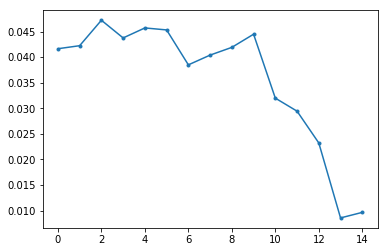

In [190]:
plt.plot(range(Q_), partial_devs_1, marker = '.')
# plt.plot(range(Q_), partial_devs_2, marker = '.')
# plt.plot(range(Q_), fits[:, 0], marker = '.')
# plt.plot(range(Q_), fits[:, 1], marker = '.')
# plt.ylim(0, .07)

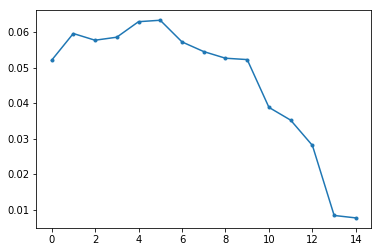

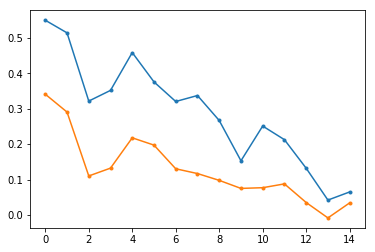

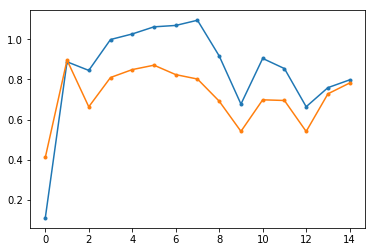

In [245]:
# Gaussian

[0.0863967  0.01296385]
[0.08842814 0.01074267]
[0.09689284 0.01611861]
[0.08432123 0.01063715]
[0.08689185 0.01206402]
[0.09146881 0.01389333]
[0.08071326 0.01385786]
[0.07617694 0.01076438]
[0.04747966 0.01308357]
[0.05237573 0.00767953]


[0.98859968 6.31536187]
[1.0726746  5.50727238]
[1.16982095 8.42172979]
[1.14772977 7.27886601]
[0.99899666 8.59448406]
[ 1.11401587 15.97862462]
[1.3146688  9.78260646]
[1.07650366 8.68275585]
[ 1.18007377 12.5288997 ]
[ 1.09623537 11.0625377 ]


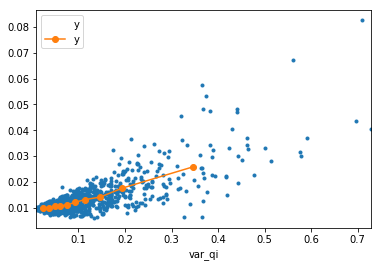

In [252]:
fig, ax = plt.subplots(1)

df_xy_q.plot('var_qi', 'y', marker = '.', lw = 0, ax = ax)
bin_mean = df_xy_q.groupby(pd.qcut(df_xy_q.var_qi, 10)).mean()
bin_mean.plot('var_qi', 'y', marker = 'o', ax = ax)

## Test at sigma = 0
What if the sigma_0 point is set at zero? what are the dependencies? 

What happens with Q and the total? The curvature of the log should have an effect

In [207]:
tot_size = 1e11
M = 50000

result_list = []
for Q in [2, 3, 4, 5, 7, 10, 15, 20, 25, 30]:
    v = []
    for var in np.arange(0, 0.005, 0.0001):
        q_size = np.log10(tot_size/Q)
#         sim_q_size_lin = np.power(10, q_size + np.random.laplace(0, np.sqrt(var), M)/np.sqrt(2))
        sim_q_size_lin = np.power(10, q_size + np.random.normal(0, np.sqrt(var), M))
        sim_log_totals = np.log10(sim_q_size_lin + (1 - 1/Q)*tot_size)
        v += [[var, sim_log_totals.var()]]

    result = pd.DataFrame(np.array(v), columns = ['var_q', 'var'])
    result['Q'] = Q
    result_list += [result]
    
result = pd.concat(result_list)

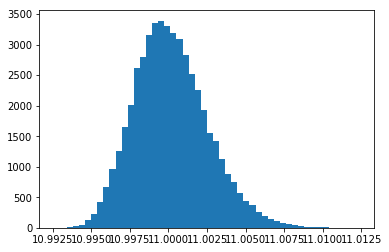

In [208]:
plt.hist(sim_log_totals, 50)
plt.show()

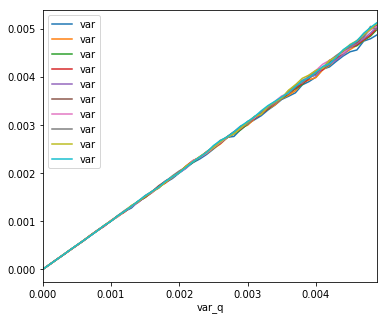

In [209]:
fig, ax = plt.subplots(1, figsize = (6, 5))

for Q in result.Q.unique()[:10]:
    slice_ = result.loc[result.Q == Q]
    slice_['var'] = Q**2*slice_['var']
    slice_.plot('var_q', 'var', ax = ax)

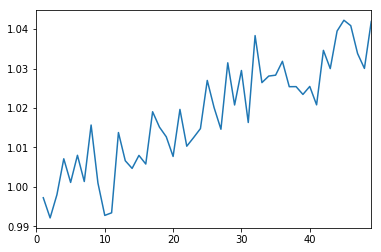

In [162]:
(slice_['var']/slice_['var_q']).plot()